In [1]:
%matplotlib inline

In [2]:
# filter the warning - created by pynndescent
import warnings
warnings.filterwarnings('ignore')

In [3]:
from importlib import reload

In [4]:
import experiment_0_import
experiment_0_import = reload(experiment_0_import)
from experiment_0_import import *

In [5]:
import tools
tools = reload(tools)
import experiment_0
experiment_0 = reload(experiment_0)

# Abstract

This notebook is dedicated to running some code and conducting some exploratory experiments.

For example:
- run t-SNE on datasets usually embedded with t-SNE
- explore different types of initialisation for t-SNE
- explore the KNN metric

# Datasets

- MNIST-2k
- MNIST-70k
- MNIST-fashion

<table>
    <tr>
        <th>dataset name</th>
        <th># of samples</th>
        <th># of classes</th>
        <th># of dimensions</th>
    </tr>        
    <tr>
        <td>MNIST-2k</td>
        <td>1797</td>
        <td>10</td>
        <td>64</td>
    </tr>        
    <tr>
        <td>MNIST-70k</td>
        <td>70k</td>
        <td>10</td>
        <td>784</td>
    </tr>        
    <tr>
        <td>MNIST-fasion</td>
        <td>70k</td>
        <td>10</td>
        <td>784</td>
    </tr>        

</table>

# 1. Running t-SNE

For this purpose, we are gonna use a state-of-the-art implementation of t-SNE, which implements the optimisations described in [10].

In [6]:
dataset = "mnist-2k" # one of: "mnist-2k", "mnist-70k", "mnist-fashion". "macosko" not available atm.
(X_train, y_train, X_test, y_test) = tools.get_dataset(dataset)

In [7]:
tsne_opt_res = []

tnse = openTSNE.TSNE(n_jobs=8,
                    callbacks=lambda it, err, emb: tsne_opt_res.append((it, err)),
                    callbacks_every_iters=1,
                    )

This object can then run the optimisation. For reference, the following table provides the time taken on a Macbook Pro 2012 with Intel Core i7 2.6 GHz:

<table>
    <tr>
        <th>dataset name</th>
        <th>user</th>
        <th>wall</th>
        <th>total</th>
    </tr>        
    <tr>
        <td>MNIST-2k</td>
        <td>3min 41s</td>
        <td>1min 5s</td>
        <td>3min 53s</td>
    </tr>        
    <tr>
        <td>MNIST-70k</td>
        <td>29min 21s</td>
        <td>16min 33s</td>
        <td>29min 58s</td>
    </tr>
</table>


In [8]:
%time emb = tnse.fit(X_train)

CPU times: user 3min 44s, sys: 11.6 s, total: 3min 56s
Wall time: 1min 4s


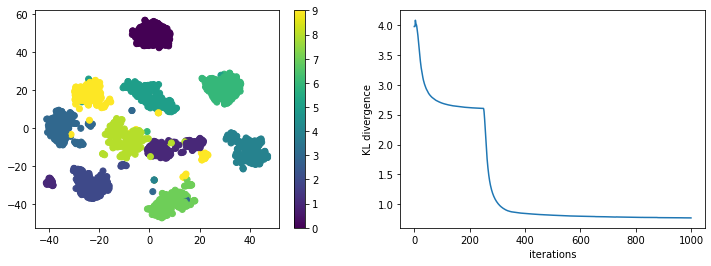

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

im = ax[0].scatter(emb[:,0], emb[:,1], c=y_train, rasterized=True)
fig.colorbar(im, ax=ax[0])

ax[1].plot(np.array(tsne_opt_res)[:,1])
ax[1].set_ylabel('KL divergence')
_=ax[1].set_xlabel('iterations')

# 2. Influence of the initialisation

In response to the problem of having different results for the t-SNE embedding in different runs, PCA initialisation has emerged as the solution for repeatibility. It is indeed, the initialisation that is chosen by default in the code above. It is however possible to investigate how different initialisation strategies affect the results.

Here, we look at random, pca and spectral embedding.

In [10]:
%time init_random = openTSNE.initialization.random(X_train)

CPU times: user 619 µs, sys: 404 µs, total: 1.02 ms
Wall time: 581 µs


In [11]:
%time init_pca = openTSNE.initialization.pca(X_train)

CPU times: user 37.2 ms, sys: 5.51 ms, total: 42.8 ms
Wall time: 11.9 ms


In [12]:
%time aff = openTSNE.affinity.PerplexityBasedNN(X_train, n_jobs=8)

CPU times: user 5.61 s, sys: 133 ms, total: 5.74 s
Wall time: 4.51 s


In [13]:
%time init_spectral = spectral_embedding(aff.P, n_components=2, eigen_solver='amg')

CPU times: user 1.13 s, sys: 36.6 ms, total: 1.17 s
Wall time: 297 ms


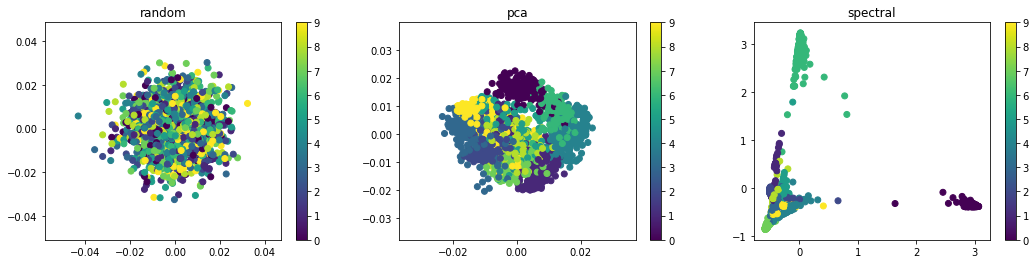

In [14]:
experiment_0.plot_inits(init_random, init_pca, init_spectral, y_train)

In [15]:
tsne_inits_res = []

In [16]:
%time tsne_init_random = experiment_0.optimize_embedding_with_init(init_random, aff, tsne_inits_res)

CPU times: user 3min 54s, sys: 13.5 s, total: 4min 8s
Wall time: 1min 2s


In [17]:
%time tsne_init_pca = experiment_0.optimize_embedding_with_init(init_pca, aff, tsne_inits_res)

CPU times: user 3min 33s, sys: 11.2 s, total: 3min 44s
Wall time: 56.8 s


In [18]:
%time tsne_init_spectral = experiment_0.optimize_embedding_with_init(init_spectral, aff, tsne_inits_res)

CPU times: user 3min 28s, sys: 10.7 s, total: 3min 39s
Wall time: 55.3 s


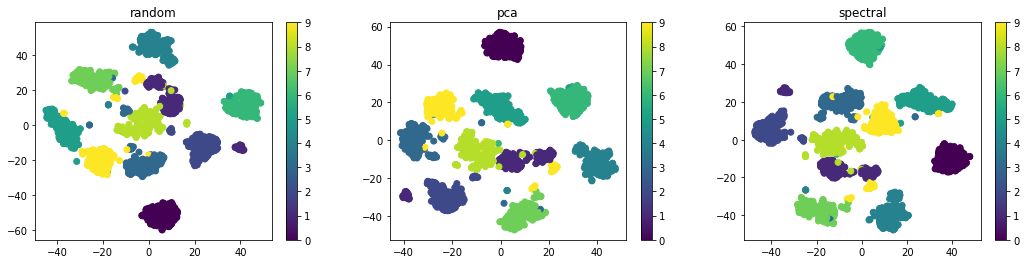

In [19]:
experiment_0.plot_inits_emb(tsne_init_random, tsne_init_pca, tsne_init_spectral, y_train)

In [20]:
tsne_inits_res_np = np.array(tsne_inits_res)

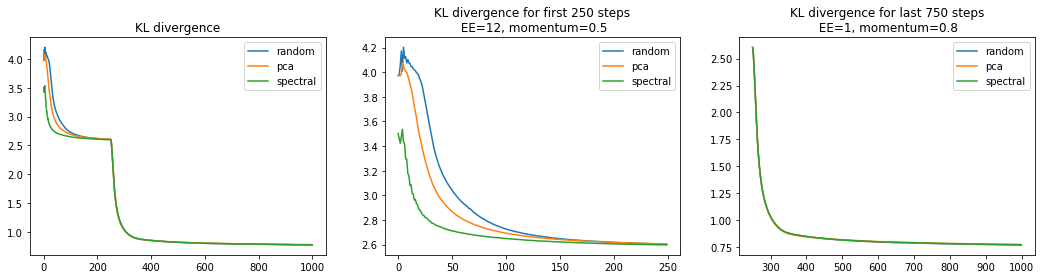

In [21]:
experiment_0.plot_inits_KL(tsne_inits_res_np)

In [22]:
print('init random KL:', tsne_inits_res_np[999,1])
print('init pca KL:', tsne_inits_res_np[1999,1])
print('init spectral KL:', tsne_inits_res_np[2999,1])

init random KL: 0.7722254784279574
init pca KL: 0.7757968605571328
init spectral KL: 0.7735864773829988


As we can see, the optimisation does end up producing a value for the KL divergence that is similar no matter the initialisation method used.

# 3. The KNN metric

It is quite common for work published on t-SNE to assess the quality of the layout by computing the performance of a K-NN classifier on the embedding produced. The classification accuracy is computed using a training and testing set.

The code below compute this metric for the embedding data given the labels:
```python
def K_NN_classifier(data, labels, K=1):

    split = sklearn.model_selection.ShuffleSplit(n_splits=1, random_state=0, test_size=0.25)
    id_train, id_test = next(split.split(data))

    nnc_train = data[id_train]
    nnc_test  = data[id_test]

    neigh = KNeighborsClassifier(n_neighbors=K)
    neigh.fit(nnc_train, labels[id_train]) 

    y_pred = neigh.predict(nnc_test)
    y_true = labels[id_test]

    return accuracy_score(y_true, y_pred)
```

In [23]:
for emb in (tsne_init_random, tsne_init_pca, tsne_init_spectral):
    print(tools.K_NN_classifier(emb, y_train))

0.9933333333333333
0.9933333333333333
0.9955555555555555


# 4. Spectral + no EE beats default parameters of openTSNE for MNIST-fashion

One interesting result we found is that using the spectral embedding and skipping the early exaggeration phase does result in a smaller final value for the KL divergence.

This result is in line with some results found by Belkina et al., who were interested in finding optimal parameters for t-sne.

# 5. Force layout

There exists different python package for force layout based techniques.

The two I tried were: 
- https://github.com/bhargavchippada/forceatlas2
- https://github.com/Iain530/force-directed-layout-algorithms

# 5.1 ForceAtlas2

ForceAtlas2 does seem to produce a nice layout for MINST-2K, but fails to do so for the more complex MNIST-70K.

For comparison, we will plot the results for openTSNE and ForceAtlas2 on MNIST-2K and MNIST-70K.

In [75]:
(X_train_2k, y_train_2k, X_test, y_test) = tools.get_dataset("mnist-2k")
(X_train_70k, y_train_70k, X_test, y_test) = tools.get_dataset("mnist-70k")

In [ ]:
# this should take an hour...
tsne_2k, tsne_70k, fa2_2k, fa2_70k = experiment_0.compare_tsne_force_mnist_2k_70k(X_train_2k, X_train_70k)

In [ ]:
# tnse = openTSNE.TSNE(n_jobs=8)

# %time tsne_2k = tnse.fit(X_train)

# # Create ForceAtlas2 object with desired parameters
# forceatlas2 = ForceAtlas2(verbose=False)

# from openTSNE import affinity

# affinities = affinity.PerplexityBasedNN(X_train)

# %time init_pca = openTSNE.initialization.pca(X_train)

# # run forceatlas2
# %time positions = forceatlas2.forceatlas2(affinities.P, pos=init_pca, iterations=1000)

# fa2_2k = np.array(positions)

# dataset = "mnist-70k" # one of: "mnist-2k", "mnist-70k", "mnist-fashion". "macosko" not available atm.
# (X_train, y_train, X_test, y_test) = tools.get_dataset(dataset)

# tnse = openTSNE.TSNE(n_jobs=8)

# %time tsne_70k = tnse.fit(X_train)

# # Create ForceAtlas2 object with desired parameters
# forceatlas2 = ForceAtlas2(verbose=False)

# from openTSNE import affinity

# affinities = affinity.PerplexityBasedNN(X_train)

# # run forceatlas2
# %time pos_70k = forceatlas2.forceatlas2(affinities.P, pos=tsne_init_pca, iterations=1000)

# fa2_70k = np.array(positions)

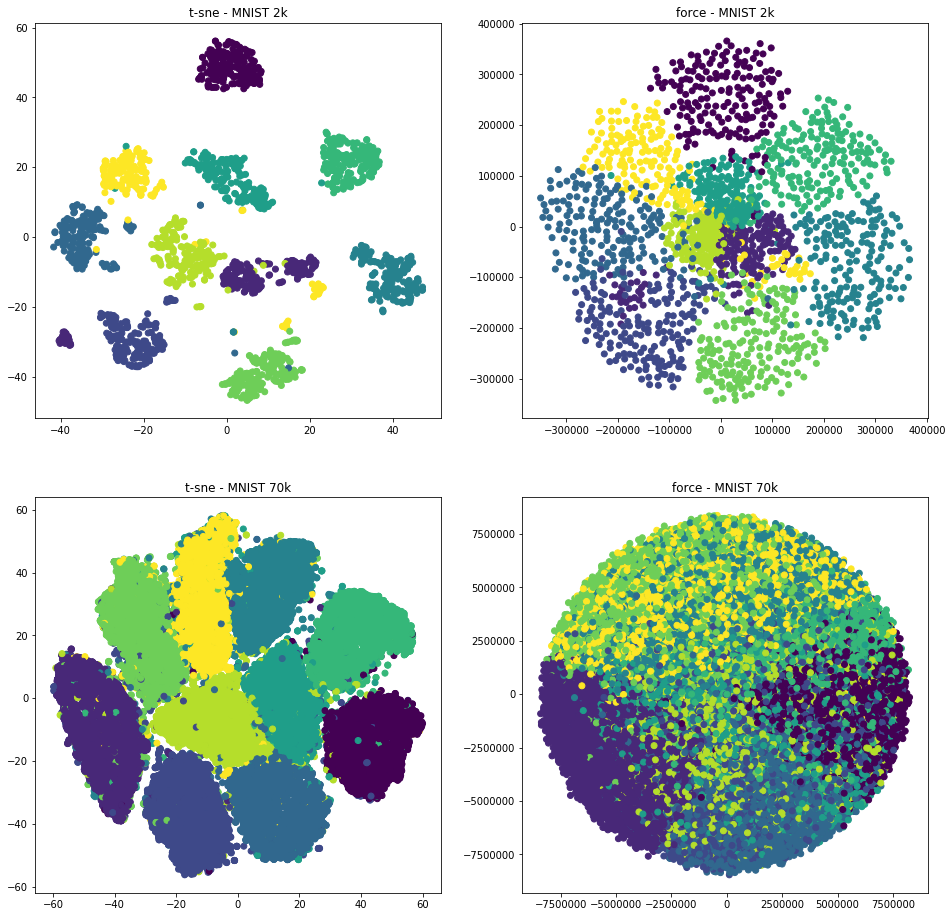

In [79]:
fig, ax = plt.subplots(2,2, figsize=(16,16))

ax[0,0].scatter(tsne_2k[:,0], tsne_2k[:,1], c=y_train_2k, rasterized=True)
ax[0,0].set_title('t-sne - MNIST 2k')

ax[0,1].scatter(fa2_2k[:,0], fa2_2k[:,1], c=y_train_2k, rasterized=True)
ax[0,1].set_title('force - MNIST 2k')

ax[1,0].scatter(tsne_70k[:,0], tsne_70k[:,1], c=y_train_70k, rasterized=True)
ax[1,0].set_title('t-sne - MNIST 70k')

ax[1,1].scatter(fa2_70k[:,0], fa2_70k[:,1], c=y_train_70k, rasterized=True)
_=ax[1,1].set_title('force - MNIST 70k')

This result look ok. However, when we switched to MNIST-70K, it does not seems to be able to produce an interesting embedding.

# 5.2 ForceLayout - Iain

This is the code that was produced during the Master project from Iain. It seems to have been heavily tested on one dataset only - the Poker dataset, and fails to produce satisfactory results with MNIST datasets. There might be some issues with the code when it comes to computing the force, as some points do end up with positions having very high values.

In [36]:
import forcelayout as fl

In [38]:
%%time
layout_chalmers = fl.NeighbourSampling(X_train)
layout_chalmers.spring_layout()

CPU times: user 39.3 s, sys: 4.61 s, total: 43.9 s
Wall time: 40.6 s


In [ ]:
embedding_chalmers = layout_chalmers.get_positions()

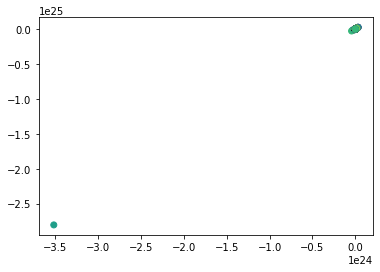

In [42]:
fig, ax = plt.subplots()
ax.scatter(embedding_chalmers[:,0], embedding_chalmers[:,1], c=y_train[:N], rasterized=True)

In [40]:
%%time
pivot_layout = fl.Pivot(X_train)
pivot_layout.spring_layout()

CPU times: user 10.6 s, sys: 1.65 s, total: 12.3 s
Wall time: 11.1 s


In [41]:
pivot_layout_pos = pivot_layout.get_positions()

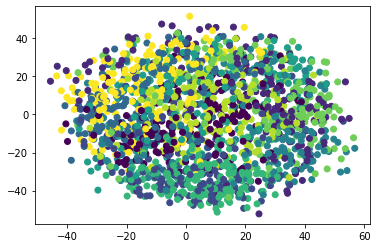

In [43]:
fig, ax = plt.subplots()
ax.scatter(pivot_layout_pos[:,0], pivot_layout_pos[:,1], c=y_train, rasterized=True)